# Final Project Rough Draft

## Introduction

### Background and Data
Pulsars are two rotating narrow beams of light that radiate pulses in different directions at regular rapid intervals.  The narrow beams are believed to be the magnetic poles, which spin rapidly as they are not in line with the spin axis. From earth, they appear to be flickering stars, but they are the size of small cities. Pulsars are believed to be neutron stars, meaning they form when the core of a star collapses upon itself in a supernova.

We are using the Predicting Pulsar Star dataset retrieved from Kaggle. Each observation in the dataset contains the mean, standard deviation, skewness, and excess kurtosis of the integrated profile and DM-SNR Curve of each star, and the observed class of each star. The integrated profile of a pulsar is the folded signal array obtained with respect to its rotational period and signal. The shape is unique to each pulsar and can be used to distinguish pulsars from one another. The other four are concerning statistics for the DM-SNR Curve. DM-SNR stands for Dispersion Measure (how the signal of a star broadens) of the Signal to Noise Ratio. 

### Question
*How do different 2-D and 4-D KNN models compare for accurately classifying the type of star based on the summary statistics of a star's integrated profile and DM-SNR Curve?*

Change phrasing: How does the best variable combination predict if a star is a pulsar
Compare best K's but still on training data
Clarify question and communication in applied context

In [2]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

#Reading the dataset and shortening the column names
pulsar_base_data = read_csv("https://raw.githubusercontent.com/NicoRui/DSCI_100_Project/main/pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) 
           
head(pulsar_base_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.031324,non_pulsar
156.39844,48.86594,-0.2159886,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.546051,112.131721,non_pulsar


In [3]:
#Splitting Data
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)
head(pulsar_train); head(pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.4498741,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.4146523,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.5083638,74.031324,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.4050084,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.5460511,112.131721,non_pulsar
79.34375,42.40217,1.0634129,2.24437669,141.641304,NA,-0.7008088,-1.200653,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
156.3984,48.86594,-0.21598860,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
83.9375,45.71272,0.74877682,1.34290171,1.747492,12.07058,11.838557,NA,non_pulsar
111.7109,46.57054,0.27286063,-0.06164600,2.139632,16.65571,9.353872,97.733760,non_pulsar
127.3281,45.33954,-0.02866461,-0.20653223,3.955686,26.25178,6.815905,46.623791,non_pulsar
108.7578,47.47084,0.23388338,-0.01183974,3.428930,22.80573,7.431087,58.339075,non_pulsar
117.6797,47.45704,0.21480140,-0.13550329,2.731605,21.99329,8.401669,71.587641,non_pulsar


In [4]:
# Table of some summary statistics fore each variable
summary(pulsar_train)

#Pulsar train and test with no NAs
pulsar_train_noNA = drop_na(pulsar_train)
pulsar_test_noNA = drop_na(pulsar_test)

#Distributional Characteristics with no NAs
summary_train_distribution = pulsar_train_noNA %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd)) %>% 
    mutate(across(where(is.numeric), round, 3))
summary_train_distribution

   mean_prof          sd_prof        kurt_prof         skew_prof      
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.625   1st Qu.:42.30   1st Qu.: 0.0230   1st Qu.:-0.1856  
 Median :115.102   Median :46.93   Median : 0.2233   Median : 0.2062  
 Mean   :110.895   Mean   :46.51   Mean   : 0.4859   Mean   : 1.8416  
 3rd Qu.:127.203   3rd Qu.:51.02   3rd Qu.: 0.4769   3rd Qu.: 0.9523  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
                                   NA's   :1410                       
   mean_DMSNR          sd_DMSNR        kurt_DMSNR       skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.945  
 1st Qu.:  1.9122   1st Qu.: 14.40   1st Qu.: 5.815   1st Qu.:  35.208  
 Median :  2.7860   Median : 18.44   Median : 8.465   Median :  83.310  
 Mean   : 12.9438   Mean   : 26.43   Mean   : 8.341   Mean   : 106.211  
 3rd Qu.:  5.3955   3rd Qu.: 28.33   3rd Qu.:10.728   3rd Qu.: 140.

target_class,mean_prof_mean,sd_prof_mean,kurt_prof_mean,skew_prof_mean,mean_DMSNR_mean,sd_DMSNR_mean,kurt_DMSNR_mean,skew_DMSNR_mean,mean_prof_sd,sd_prof_sd,kurt_prof_sd,skew_prof_sd,mean_DMSNR_sd,sd_DMSNR_sd,kurt_DMSNR_sd,skew_DMSNR_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,116.716,47.316,0.209,0.388,8.970,23.246,8.914,115.468,17.586,6.156,0.335,0.998,24.857,16.744,4.313,110.374
pulsar,56.086,38.607,3.179,16.080,51.245,56.557,2.765,18.455,30.094,8.157,1.921,14.615,46.618,20.025,3.155,48.350


In [20]:
#Standardization of all predictor variables
group_by(pulsar_train_noNA, target_class) %>% summarize(n = n())

pulsar_train_upsample_recipe = recipe(target_class~., data = pulsar_train_noNA) %>% 
        step_upsample(target_class, over_ratio = 1, skip = FALSE) %>% 
        prep()
pulsar_train_upsample = bake(pulsar_train_upsample_recipe, pulsar_train_noNA)

pulsar_recipe_train = recipe(target_class~., data = pulsar_train_upsample) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe_train, pulsar_train_upsample)

group_by(scaled_pulsar_train, target_class) %>% summarize(n = n())

pulsar_recipe_test = recipe(target_class~., data = pulsar_test_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe_test, pulsar_test_noNA)
head(scaled_pulsar_test)

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,691


`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,6711


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


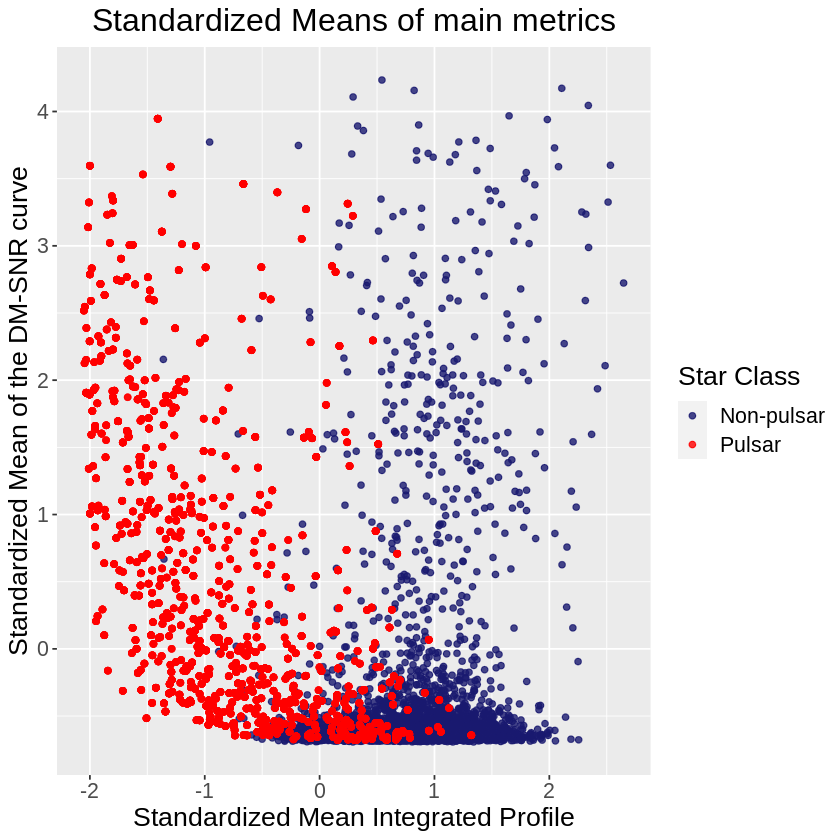

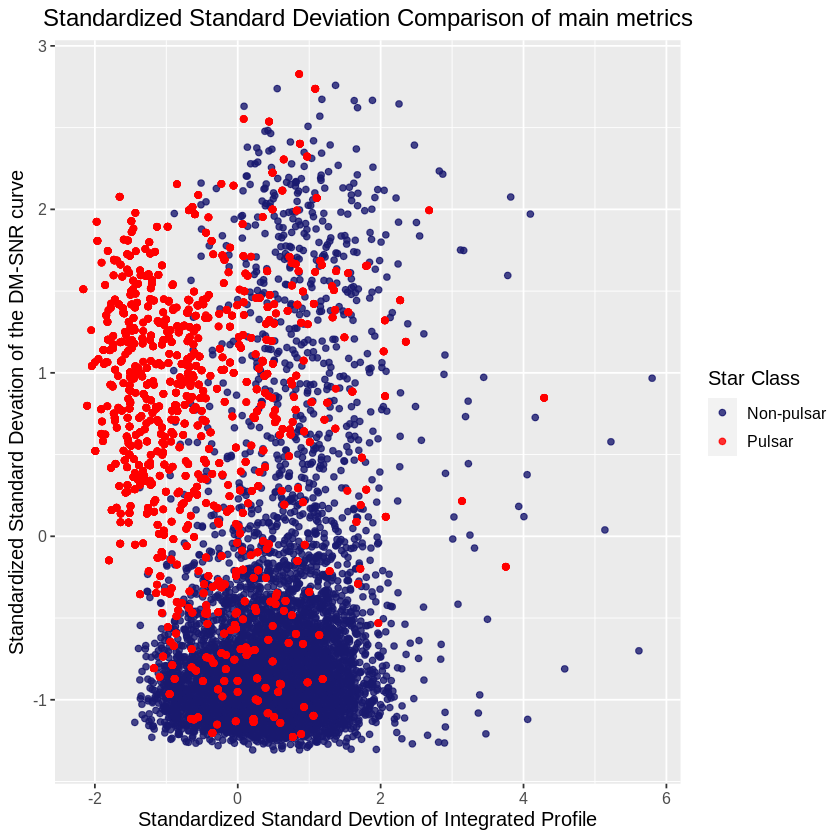

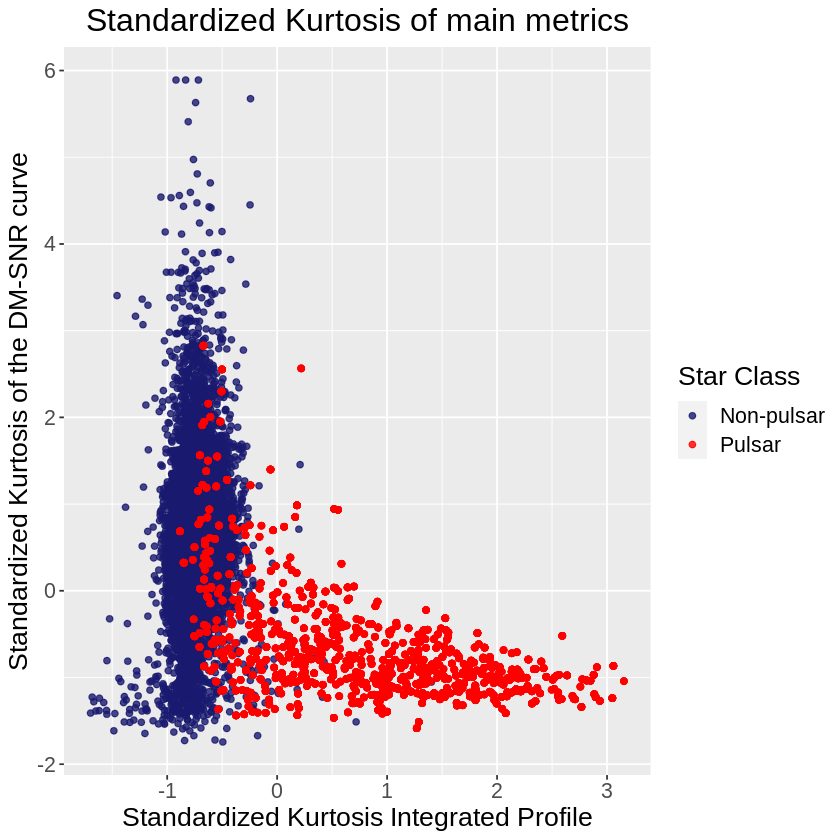

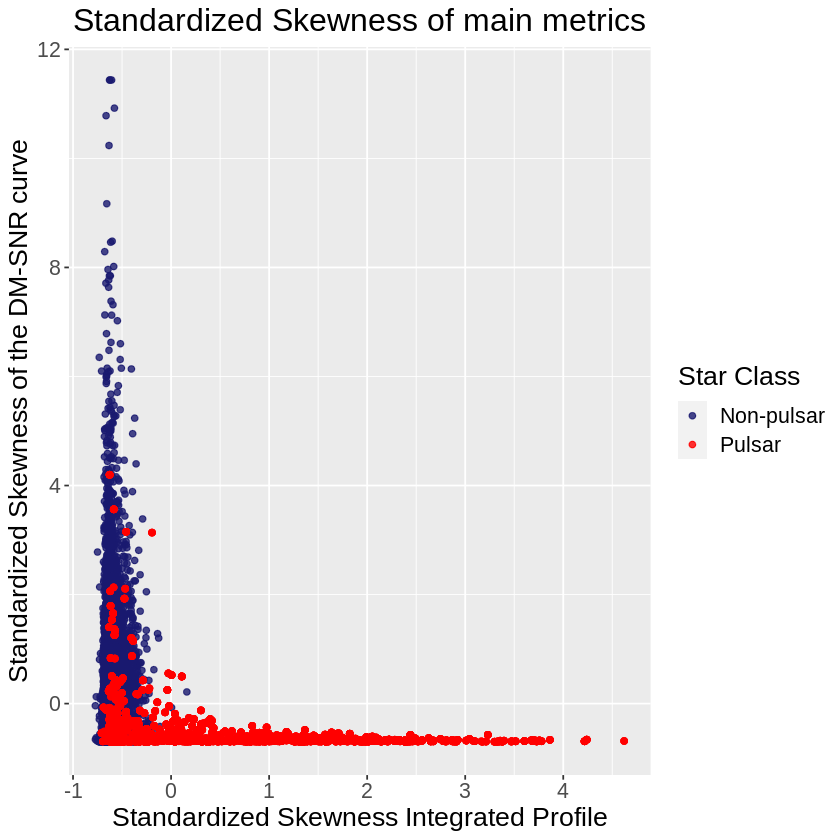

In [17]:
#Visualization for each 2-D pairing, as shown in class
mean_scaled_vis = ggplot(scaled_pulsar_train, aes(x = mean_prof, y = mean_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Mean Integrated Profile", y = "Standardized Mean of the DM-SNR curve",
           color = "Star Class", title = "Standardized Means of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
mean_scaled_vis

sd_scaled_vis = ggplot(scaled_pulsar_train, aes(x = sd_prof, y = sd_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Standard Devtion of Integrated Profile",
         y = "Standardized Standard Devation of the DM-SNR curve",
           color = "Star Class", 
         title = "Standardized Standard Deviation Comparison of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
sd_scaled_vis

kurt_scaled_vis = ggplot(scaled_pulsar_train, aes(x = kurt_prof, y = kurt_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Kurtosis Integrated Profile",
         y = "Standardized Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Standardized Kurtosis of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
kurt_scaled_vis

skew_scaled_vis = ggplot(scaled_pulsar_train, aes(x = skew_prof, y = skew_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Skewness Integrated Profile",
         y = "Standardized Skewness of the DM-SNR curve",
           color = "Star Class", title = "Standardized Skewness of main metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
skew_scaled_vis

## Models
### Means Model

### Standard Deviation Model

In [28]:
#Standardization of all predictor variables
sd_recipe_train = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_sd_train = bake(sd_recipe_train, scaled_pulsar_train)
head(scaled_sd_train)

sd_recipe_test = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_sd_test = bake(sd_recipe_test, scaled_pulsar_test)
head(scaled_sd_test)
set.seed(781)
sd_vfold = vfold_cv(scaled_sd_train, v = 5, strata = target_class)
gridvals = tibble(neighbors = seq(1,10))
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")    

sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.6370091,-0.8631787,non_pulsar
-0.8068877,-0.8963830,non_pulsar
1.2119158,-0.7043186,non_pulsar
-0.8137415,-0.7742468,non_pulsar
1.5295206,-0.8192002,non_pulsar
-0.3281405,-0.8704589,non_pulsar


sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.002139272,-0.498483074,non_pulsar
-0.187662501,0.001776142,non_pulsar
0.140952188,-0.177872560,non_pulsar
0.138825140,-0.220226313,non_pulsar
-0.885023856,-0.259193888,non_pulsar
0.430033563,0.157397274,non_pulsar


In [29]:
set.seed(781)
sd_fit = workflow() %>% 
    add_recipe(sd_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = sd_vfold, grid = gridvals) %>% 
    collect_metrics() 
# recipe_step = workflow() %>% add_recipe(sd_recipe_train); print("Done S1")
# model_step = recipe_step %>% add_model(knn_spec); print("Done S2")
# tune_step = model_step %>% tune_grid(resamples = sd_vfold, grid = gridvals); print("Done S3")
# metrics_step = collect_metrics(tune_step); print("Done S4")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9772013,5,0.00152082,Model01


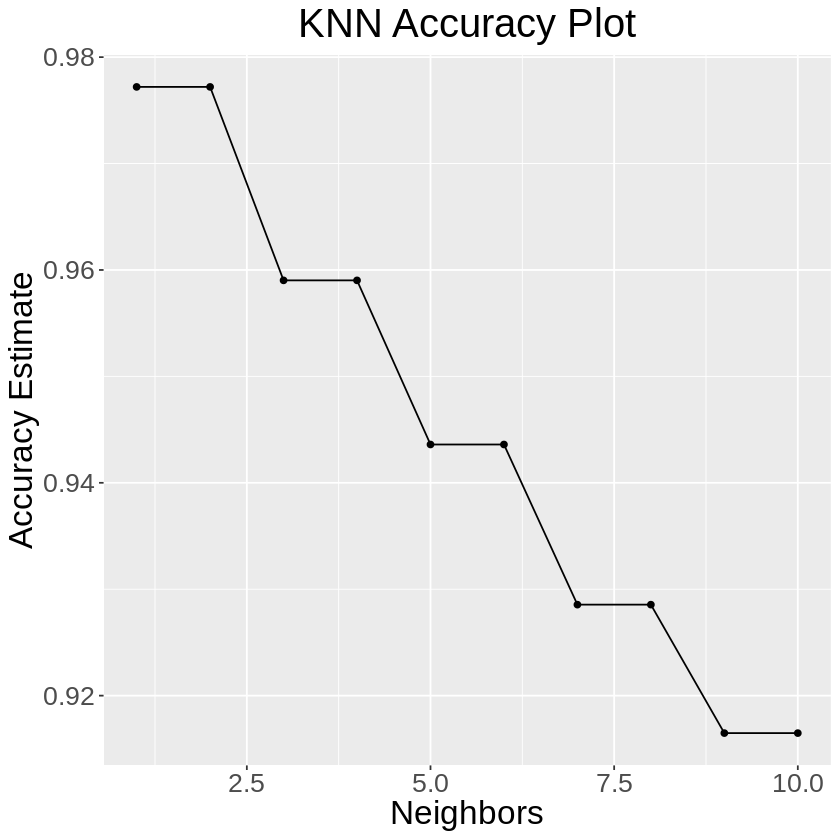

In [30]:
sdFitAccuracy = filter(sd_fit, .metric == "accuracy")

ACC_plot = ggplot(sdFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

BestKaccuracySD <- sdFitAccuracy %>%
arrange(desc(mean))%>%
slice(1)
BestKaccuracySD

### Skewness Model

In [31]:
#Standardization of all predictor variables
skew_recipe_train = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_skew_train = bake(skew_recipe_train, scaled_pulsar_train)
head(scaled_skew_train)

skew_recipe_test = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_test) %>%
                    prep()
scaled_skew_test = bake(skew_recipe_test, scaled_pulsar_test)
head(scaled_skew_test)

set.seed(781)
skew_vfold = vfold_cv(scaled_skew_train, v = 5, strata = target_class)

skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6329118,-0.02079576,non_pulsar
-0.3698248,0.36126441,non_pulsar
-0.6548811,0.06944162,non_pulsar
-0.3786869,0.09242608,non_pulsar
-0.6275438,0.30686587,non_pulsar
-0.5427129,0.03659553,non_pulsar


skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.28857476,-0.05490509,non_pulsar
-0.31459801,-0.55910137,non_pulsar
-0.27962898,-0.44353091,non_pulsar
-0.30184039,-0.31283473,non_pulsar
-0.01691419,-0.29278131,non_pulsar
-0.33386356,-0.66868236,non_pulsar


In [32]:
set.seed(781)
skew_fit = workflow() %>%
    add_recipe(skew_recipe_train) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = skew_vfold, grid = gridvals) %>%
    collect_metrics()

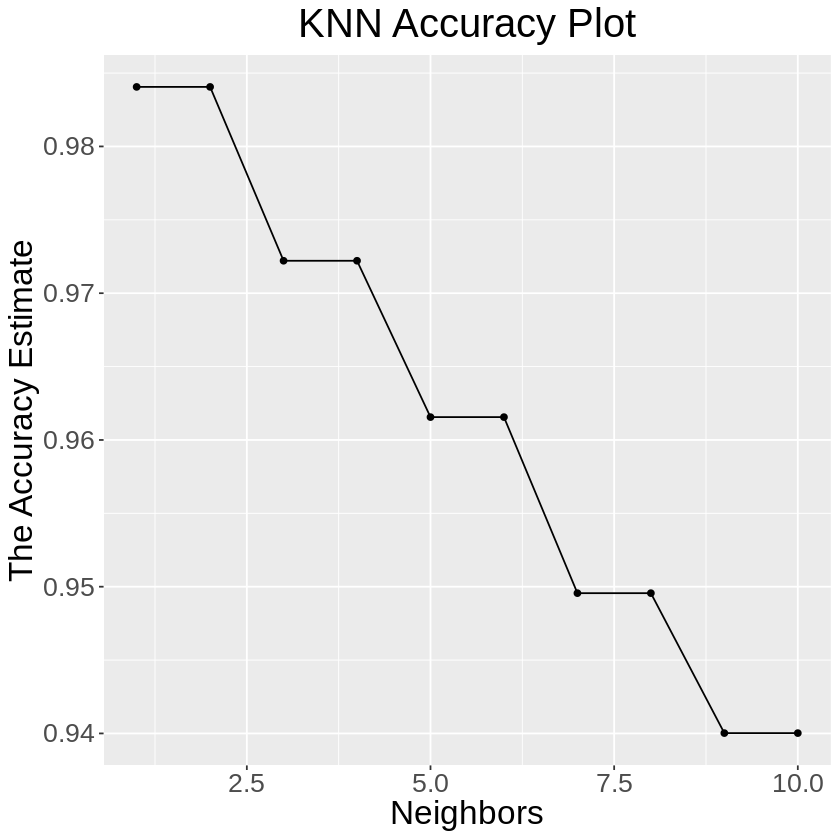

In [33]:
skewFitAccuracy <- filter(skew_fit, .metric == "accuracy")

accuracy_plot <- ggplot(skewFitAccuracy, aes(x = neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot

In [34]:
BestKaccSkew = skewFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccSkew

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9840568,5,0.001507898,Model01


### Kurtosis Model

In [35]:
#Standardization of all predictor variables
kurt_recipe_train = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_kurt_train = bake(kurt_recipe_train, scaled_pulsar_train)
head(scaled_kurt_train)
kurt_recipe_test = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_kurt_test = bake(kurt_recipe_test, scaled_pulsar_test)
head(scaled_kurt_test)
set.seed(781)
kurt_vfold = vfold_cv(scaled_kurt_train, v = 5, strata = target_class)

kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6496326,0.3284489,non_pulsar
-0.4822592,0.7308359,non_pulsar
-0.7697144,0.5452278,non_pulsar
-0.4266446,0.5240606,non_pulsar
-0.5555712,0.7366994,non_pulsar
-0.6634757,0.4106415,non_pulsar


kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.18496543,0.24305640,non_pulsar
-0.49151524,-0.33098399,non_pulsar
-0.22459219,-0.19184137,non_pulsar
-0.24399215,0.02768594,non_pulsar
0.08090689,-0.06350674,non_pulsar
-0.32417289,-0.53718862,non_pulsar


In [36]:
set.seed(781)
kurt_fit = workflow() %>% 
    add_recipe(kurt_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = kurt_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9866635,5,0.0006919408,Model01


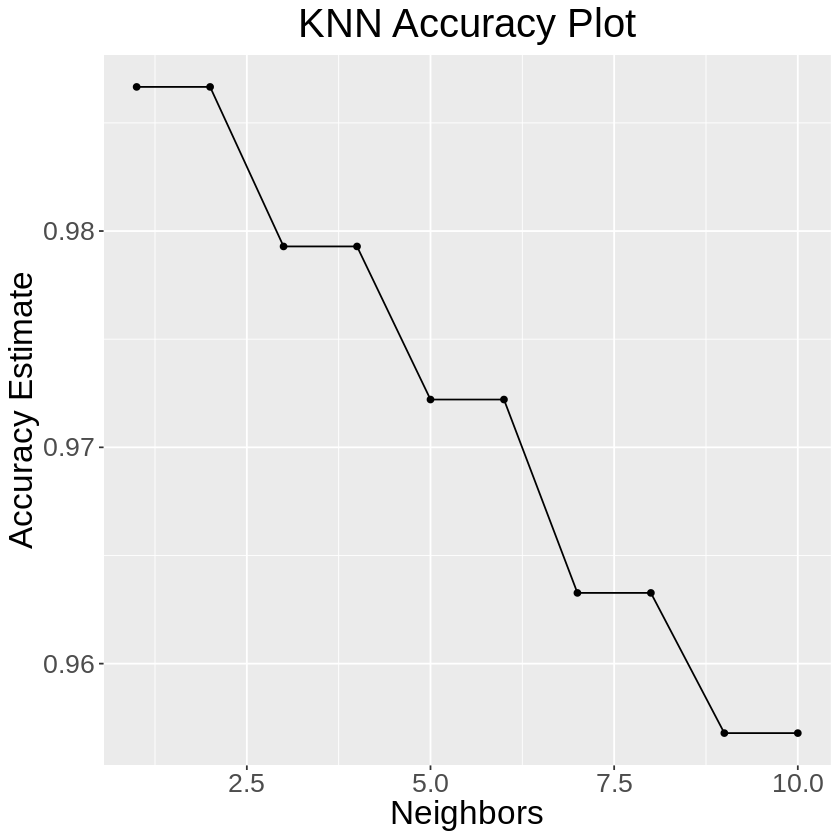

In [37]:
kurtFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot = ggplot(kurtFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

BestKaccKurt = kurtFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccKurt

### Profile Model

In [46]:
#Standardization of all predictor variables
profile_recipe_train = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_train) %>% 
                    prep()
scaled_profile_train = bake(profile_recipe_train, scaled_pulsar_train)
head(scaled_profile_train)

profile_recipe_test = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_test) %>% 
                    prep()
scaled_profile_test = bake(profile_recipe_test, scaled_pulsar_test)
head(scaled_profile_test)

set.seed(781)
profile_vfold = vfold_cv(scaled_profile_train, v = 5, strata = target_class)

mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.88934352,0.6370091,-0.6496326,-0.6329118,non_pulsar
-0.24377002,-0.8068877,-0.4822592,-0.3698248,non_pulsar
1.13115187,1.2119158,-0.7697144,-0.6548811,non_pulsar
-0.04283068,-0.8137415,-0.4266446,-0.3786869,non_pulsar
0.58803469,1.5295206,-0.5555712,-0.6275438,non_pulsar
0.21881116,-0.3281405,-0.6634757,-0.5427129,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,non_pulsar


In [47]:
set.seed(781)
profile_fit = workflow() %>% 
    add_recipe(profile_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = profile_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9866635,5,0.0006919408,Model01


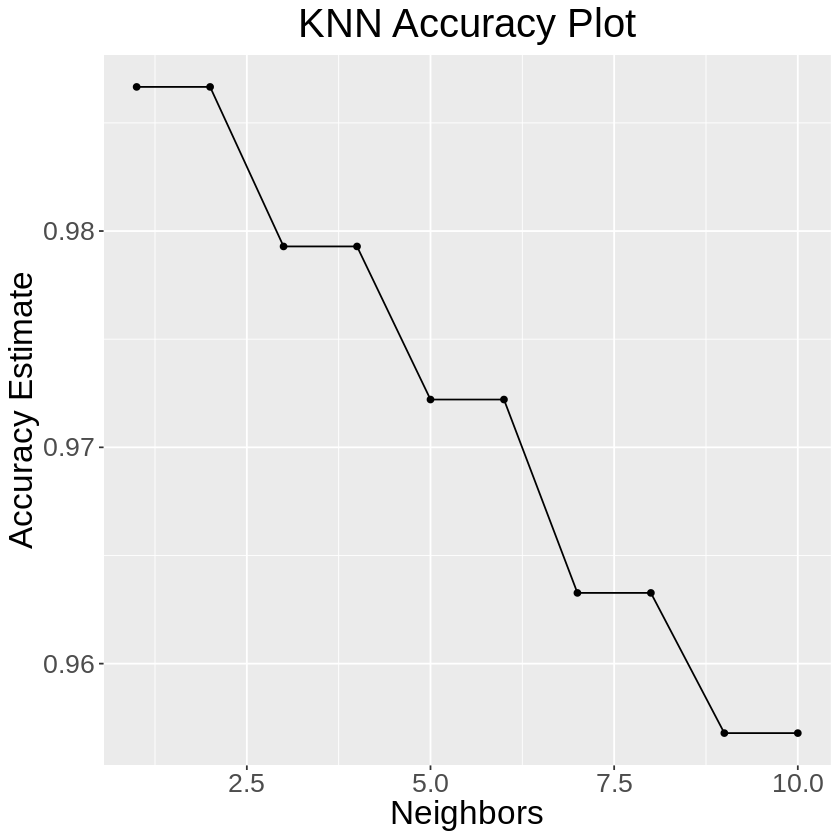

In [48]:
ProfFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot = ggplot(ProfFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

BestKaccProf = ProfFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccProf

### DMSNR Model

In [51]:
#Standardization of all predictor variables
DMSNR_recipe_train = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_DMSNR_train = bake(DMSNR_recipe_train, scaled_pulsar_train)
head(scaled_DMSNR_train)

DMSNR_recipe_test = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_DMSNR_test = bake(DMSNR_recipe_test, scaled_pulsar_test)
head(scaled_DMSNR_test)

set.seed(781)
DMSNR_vfold = vfold_cv(scaled_DMSNR_train, v = 5, strata = target_class)

mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.6282865,-0.8631787,0.3284489,-0.02079576,non_pulsar
-0.6461742,-0.8963830,0.7308359,0.36126441,non_pulsar
-0.6381830,-0.7043186,0.5452278,0.06944162,non_pulsar
-0.6370942,-0.7742468,0.5240606,0.09242608,non_pulsar
-0.6369192,-0.8192002,0.7366994,0.30686587,non_pulsar
-0.6375609,-0.8704589,0.4106415,0.03659553,non_pulsar


mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


In [53]:
set.seed(781)
kurt_fit = workflow() %>% 
    add_recipe(DMSNR_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = DMSNR_vfold, grid = gridvals) %>% 
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9734025,5,0.001383837,Model01


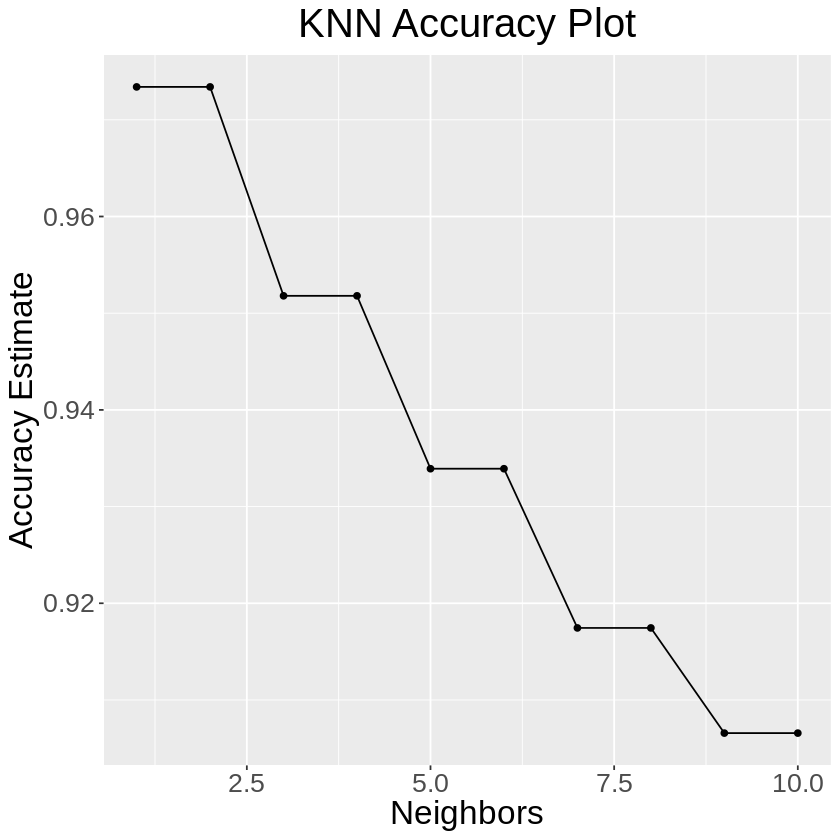

In [54]:
DMSNRFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot = ggplot(DMSNRFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

BestKaccDMSNR = DMSNRFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)
BestKaccDMSNR

In [ ]:
tibble(Best)

## References

Cofield, C. (2016, April 22). What Are Pulsars? Space.com. 
https://www.space.com/32661-pulsars.html. 

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & 
Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17=

Hobbs, M. (2020, November 17). An Introduction to Pulsars. Australia Telescope National 
Facility. https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html.

Lounge, C.-learning. (2020, August 26). Predicting Pulsar Star. Kaggle. 
https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate?select=pulsar_data_train.csv. 

Rowan, L., & Coontz, R. (2004, April 23). The Strange and Twisted World of Pulsars. 
Science. https://science.sciencemag.org/content/304/5670/531.  

Lyon, R. (2017, February 14). HTRU2 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/HTRU2

Swinburne University of Technology. (2020). Pulsar Dispersion Measure. COSMOS. https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure

The University of Sheffield. (n.d.). L14 Signal-to-Noise. PHY217 Observational Techniques for Astronomers. http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html